In [1]:
# Notebook for our experiemnt on slabs
"""The value of index n can be extracted by comparing the M(theta) data with functional shapes 
computed for a set of candidate n-values."""

'The value of index n can be extracted by comparing the M(theta) data with functional shapes \ncomputed for a set of candidate n-values.'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

In [3]:
# T = 1e-3 # thickness of slab in mm
n = 1.5 # guess of index of refraction
lambda_HeNe = 632.99e-9 # wavelength of laser in nm (vacuum)
path = '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'

In [60]:
# Defining functions we will use later

def get_n(theta, M, T):
    """Function to get index of refraction; from TeachSpin article Chap 11-5"""
#     Converting theta to radians (fed in in degrees)
    theta_rad = (theta *np.pi) / 180
    
    
    alpha = (M * lambda_HeNe)/ (2*T)
    n = ((alpha**2) + 2 *((1 - np.cos(theta_rad))*(1-alpha))) / (2*(1 - np.cos(theta_rad) - alpha))
    return np.mean(n)
    
def getM(x, n, T):
    """Function to get the fringe count M as a function of theta
        function shape depends on thickness T and index of refraction of the slab"""
    M = (2 * T * (n-1) * (x **2))/(lambda_HeNe * 2*n)
    
    return M

# def quadModel(x,a,b,c):
#     """Function to return a quadratic fit: ax**2 + b"""
#     return a*(x**2) + b*x + c

# def errorSquare(x,a,sigma_a, y=2):
#     '''Error propagation of parameter a with 
#         relationship x = a^y (a takes the place of theta here)'''
#     if (a != 0.0):
#         sigma_x = y * x * (sigma_a/a)
#         return sigma_x
    
#     elif (a == 0.):
#         return 0
    
def cosineModel(theta, n):
#     Model from class: uses cosines; should be a better fit, n as a free param
    theta_rad = theta * np.pi / 180. # conversion to radians from degrees
    theta_prime = np.arcsin(np.sin(theta_rad)/n)
#     Phase shift of light phi, can determine M from phi (4 counts equals 2pi phase shift)
    phi = ((np.pi * 2 * 0.5e-3)/lambda_HeNe) * \
    ((n - np.cos(theta_rad - theta_prime)/np.cos(theta_prime) - (n - 1)))
    
    M = phi * (-4/np.pi) * (2*np.pi/lambda_HeNe) # should have double
    return M

# /def errorCosine()

# ######################################################################################################
# ######################################################################################################

def makePlots(filename):
    '''Function that replaces the blocks of code written below.
        Takes in filename, reads file and then fixes data (sums counts, resets max, etc.),
        plots datas along with fit model which we are using (cosine Model) '''
    
    path = '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'
    data = pd.read_csv(path + filename)
    testNum = filename[24]

    print(f'###################### Test #: {testNum} ####################')
    print('')    
    
#     Summing up counts, comment out if did not reset in between data runs
    new_counts = []
    c=0
    for index,row in data.iterrows():
    
        c += row['Counts (M)']
        new_counts.append(c)
        
#     Assigning columns variable names to be used later
    data['new counts'] = new_counts
    print(data)
    
    theta = data['theta (deg)']
    theta_rad = (theta.values * np.pi)/180 # Converting theta values to radians for rest of this
    theta_err = data['theta_err (deg)'] # all 1 deg
    theta_err_rad = theta_err * (np.pi/180.) # theta error in radians
    counts = data['new counts'] / 2
    
# #####################################################################################

#     Fitting the counts-theta data
    fitCoeffs, fitCovariances = curve_fit(cosineModel, theta_rad, counts)
    
    # Bestfit params returned from our model
    bestfit_n = fitCoeffs[0]
    print(f'The model bestfit for fit param n is: {bestfit_n}')
    
#     Creating quadratic fit, input array of theta values with fitted array (quad)
    theta_input = np.arange(np.min(theta_rad), np.max(theta_rad) + 0.05, 0.05)
    cos = cosineModel(theta_input, bestfit_n)

#     Determining error values in M, will depend on error in theta

    errM = [abs(errorSquare(m, t, sig, 2)) for m,t,sig in zip(counts, theta_rad, theta_err_rad)]
    print('Error Values for M: ', errM)

# ############################################################################################
        
    # Plotting counts versus theta (angle relative to start)
    f,ax = plt.subplots()
    ax.errorbar(theta_rad, counts, xerr = theta_err_rad, yerr = errM, fmt = 'o')
    ax.set_xlabel(r'$\theta$ (radians)', fontsize = 16)
    ax.set_ylabel('Counts, M',fontsize = 16)

    # Plotting fit model calculated above
    ax.plot(theta_input, cos, c = 'r')
    ax.set_title('Test ' + testNum, fontsize = 16)
    f.savefig('../plots/' + 'quadFit-Test-' + testNum + '.pdf') # Saving figure to our plots directory

#     returning index of refraction given by our fit model (division by 2 accounts for path length double)
    return bestfit_n
    

###################### Test #: 5 ####################

    theta (deg)  theta_err (deg)  Counts (M)  new counts
0             0              0.5           0         0.0
1             2              0.5           1         1.0
2             4              0.5           2         3.0
3             6              0.5           8        11.0
4             8              0.5          10        21.0
5            10              0.5          17        38.0
6            12              0.5          16        54.0
7            14              0.5          23        77.0
8            16              0.5          17        94.0
9            18              0.5          20       114.0
10           20              0.5          38       152.0
The model bestfit for fit param n is: 1.9998653794292125
Error Values for M:  [0, 0.25, 0.375, 0.9166666666666667, 1.3125, 1.9000000000000001, 2.2500000000000004, 2.75, 2.9375, 3.166666666666667, 3.8000000000000003]


1.9998653794292125

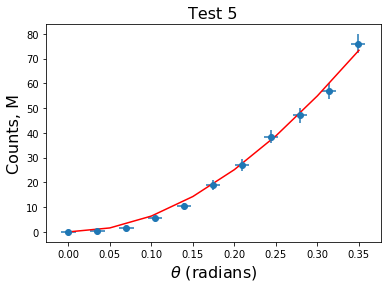

In [61]:
# Test call of makePlots function - use for best test we did
makePlots('slab-Index-of-Refraction5.csv')

###################### Test #: 4 ####################

    theta (deg)  theta_err (deg)  Counts (M)                 Notes  new counts
0           -10              0.5           0  new small step tiral           0
1            -8              0.5         -12                   NaN         -12
2            -6              0.5         -10                   NaN         -22
3            -4              0.5          -3                   NaN         -25
4            -2              0.5          -6                   NaN         -31
5             0              0.5          -2                   NaN         -33
6             2              0.5           3                   NaN         -30
7             4              0.5           6                   NaN         -24
8             6              0.5           4                   NaN         -20
9             8              0.5          13                   NaN          -7
10           10              0.5          16                   NaN          

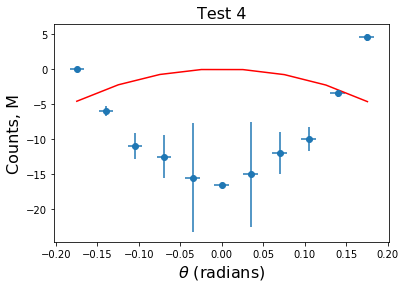

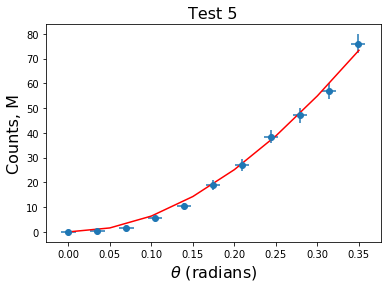

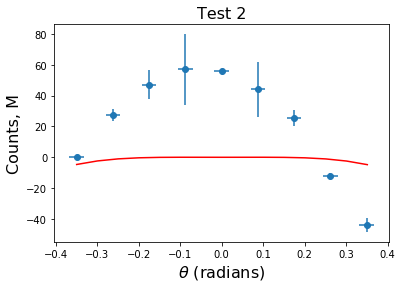

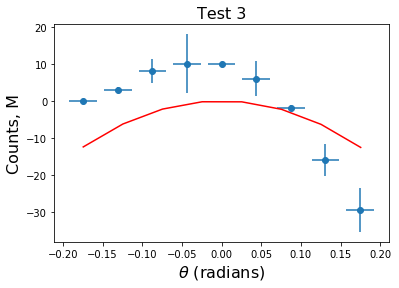

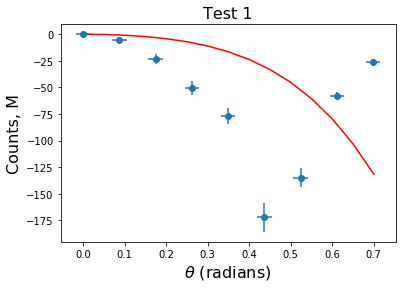

In [40]:
# Walking through entire slabs data directory and creating plots for each trial
indices = [] # from fit
count_index = []
for file, root,names in os.walk(path, topdown = True):
    for name in names:
        nFit = makePlots(name)/2
        indices.append(nFit)
        
        
#         n = makePlots(name)[1] / 2 
#         count_index.append(n)

        
        print('')
        


In [27]:
print(count_index)

[0.24102926900056437, 1.8570016492632266, -0.7056633168726372, 0.023629618273428517, 0.3255620746452264]


In [28]:
print(indices)
print('mean index of refraction: ', np.mean(indices),'counts :',np.mean(count_index))
print("std dev", np.std(indices), np.std(count_index))
print('')


[1.000014678712523, 0.9999326897146062, 0.9999993679926262, 1.0000415772135127, 1.0000094359357268]
mean index of refraction:  0.9999995499137991 counts : 0.3483118588619617
std dev 3.6230449163716505e-05 0.8371922382402572

